In [150]:
# import
import cv2
import pickle
import math
import numpy as np
import pandas as pd
import seaborn as sns
import pyautogui as pg

from time import time, sleep
from tqdm import tqdm
from tqdm.notebook import trange
from numba import jit
from pprint import pprint
from joblib import Parallel, delayed
from sklearn import svm, neural_network
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from threading import Thread
from matplotlib import pyplot as plt
from line_profiler import LineProfiler

camera = cv2.VideoCapture(0)
CAMERA_SIZE = (50, 85)

LEFT_ACTCODE = 0
RIGHT_ACTCODE = 1
LEFT90_ACTCODE = 2
RIGHT90_ACTCODE = 3
STRAIGHT_ACTCODE = 4


def SaveInstances(instance, path):
    '''
    PickleモジュールのWrapper
    instanceのオブジェクトをpathで指定したファイルパスに保存する。
    '''
    with open(path, mode='wb') as file:
        pickle.dump(instance, file, protocol=2)


def LoadInstances(path):
    '''
    PickleモジュールのWrapper
    pathに保存されているpickle形式のファイルをオブジェクトとして読み込む。
    '''
    with open(path, 'rb') as ins:
        return pickle.load(ins)


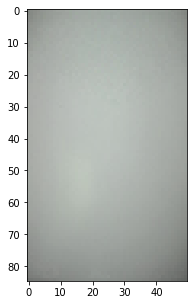

In [151]:
# 白色のRGB値サンプルを取る

ret, raw_frame = camera.read()
frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
height, width = frame.shape[:2]

WhiteRGB_sample = [frame[i, j] for i in range(height) for j in range(width)]

img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig = plt.figure(1, (5., 5.))
plt.imshow(img)


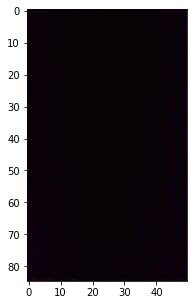

In [160]:
# 黒色のRGB値サンプルを取る

ret, raw_frame = camera.read()
frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
height, width = frame.shape[:2]

BlackRGB_sample = [frame[i, j] for i in range(height) for j in range(width)]

img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig = plt.figure(1, (5., 5.))
plt.imshow(img)


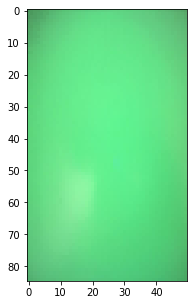

In [163]:
# 緑色のRGB値サンプルを取る

ret, raw_frame = camera.read()
frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
height, width = frame.shape[:2]

GreenRGB_sample = [frame[i, j] for i in range(height) for j in range(width)]

img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig = plt.figure(1, (5., 5.))
plt.imshow(img)


In [164]:
# 色識別の分類モデルを作る(SVM)

# それぞれの色に0,1,2の分類をつける
WhiteRGB_sample = [[point[0], point[1], point[2], 0] for point in WhiteRGB_sample]
BlackRGB_sample = [[point[0], point[1], point[2], 1] for point in BlackRGB_sample]
GreenRGB_sample = [[point[0], point[1], point[2], 2] for point in GreenRGB_sample]

allOf_samples = np.concatenate([WhiteRGB_sample, BlackRGB_sample, GreenRGB_sample])

# SaveInstances(instance=allOf_samples, path="allOf_samples.pickles")
allOf_samples = LoadInstances(path="allOf_samples.pickles")

X_train, X_test, y_train, y_test = train_test_split(
    allOf_samples[:, :-1],
    allOf_samples[:, -1:],
    stratify=allOf_samples[:, -1:],  # テストに使うデータを階層化する
    test_size=0.3,  # テストに使う割合
)

model = svm.SVC().fit(X_train, y_train)


C:\Users\Haya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


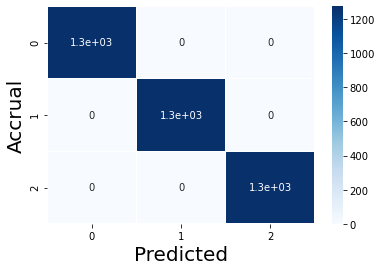

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1275
           1       1.00      1.00      1.00      1275
           2       1.00      1.00      1.00      1275

    accuracy                           1.00      3825
   macro avg       1.00      1.00      1.00      3825
weighted avg       1.00      1.00      1.00      3825



In [165]:
# 色識別の分類モデルをテストする

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidth=0.3)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Accrual", fontsize=20)
plt.show()

print(classification_report(y_test, y_pred))


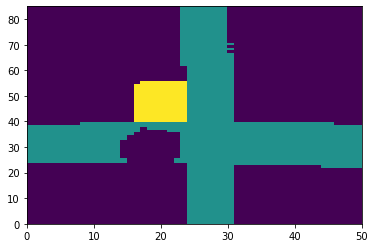

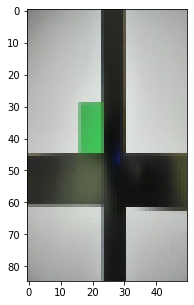

Timer unit: 1e-07 s

Total time: 0.407624 s
File: C:\Users\Haya\AppData\Local\Temp/ipykernel_692/470189583.py
Function: func_Classification at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def func_Classification():
     3         1      66441.0  66441.0      1.6      ret, raw_frame = camera.read()
     4         1        948.0    948.0      0.0      frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
     5         1         52.0     52.0      0.0      height, width = frame.shape[:2]
     6                                           
     7         1     224398.0 224398.0      5.5      result = [model.predict(row) for row in reversed(frame)]
     8                                           
     9         1       9576.0   9576.0      0.2      plt.clf()
    10         1     351430.0 351430.0      8.6      plt.pcolormesh(result)
    11         1    1672842.0 1672842.0     41.0      plt.pause(0.01)
    12          

In [167]:
# 色識別の分類モデルを使って、タイルを色分類してみる
def func_Classification():
    ret, raw_frame = camera.read()
    frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
    height, width = frame.shape[:2]

    result = [model.predict(row) for row in reversed(frame)]

    plt.clf()
    plt.pcolormesh(result)
    plt.pause(0.01)

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.01)


lp = LineProfiler()
lp.add_function(func_Classification)
lp.runcall(func_Classification)
lp.print_stats()


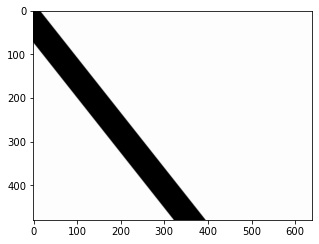

In [168]:
# タイルのサンプルを集める (左に曲がる)
Left_videoPath = "C:/Users/Haya/OneDrive/デスクトップ/部活関係/ロボカップ2022/left_vid.mp4"

vid = cv2.VideoCapture(Left_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)


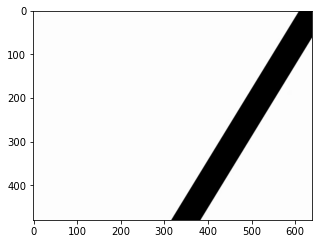

In [169]:
# タイルのサンプルを集める (右に曲がる)
Right_videoPath = "C:/Users/Haya/OneDrive/デスクトップ/部活関係/ロボカップ2022/right_vid.mp4"

vid = cv2.VideoCapture(Right_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)


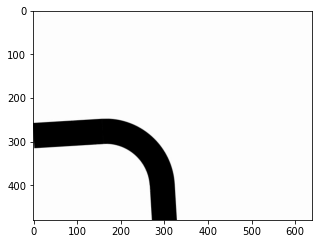

In [170]:
# タイルのサンプルを集める (90度に左に曲がる)
Left90_videoPath = "C:/Users/Haya/OneDrive/デスクトップ/部活関係/ロボカップ2022/left90_vid.mp4"

vid = cv2.VideoCapture(Left90_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)


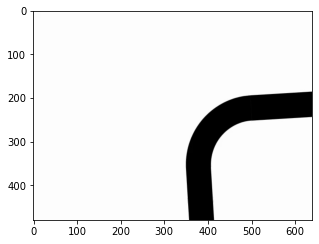

In [171]:
# タイルのサンプルを集める (90度に右に曲がる)
Right90_videoPath = "C:/Users/Haya/OneDrive/デスクトップ/部活関係/ロボカップ2022/right90_vid.mp4"

vid = cv2.VideoCapture(Right90_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)


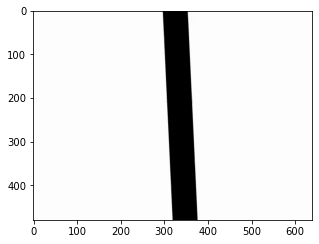

In [172]:
# タイルのサンプルを集める (真っ直ぐ進む)
Straight_videoPath = "C:/Users/Haya/OneDrive/デスクトップ/部活関係/ロボカップ2022/stright_vid.mp4"

vid = cv2.VideoCapture(Straight_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)


In [173]:
# ライントレースの判断モデルを作る(NeuralNetwork)
pathList = [
    # それぞれの行動パターンに番号を振り与える
    [Left_videoPath, LEFT_ACTCODE],
    [Right_videoPath, RIGHT_ACTCODE],
    [Left90_videoPath, LEFT90_ACTCODE],
    [Right90_videoPath, RIGHT90_ACTCODE],
    [Straight_videoPath, STRAIGHT_ACTCODE],
]

model = LoadInstances("ColorModel.pickle")
allOf_samples = np.empty((1, CAMERA_SIZE[0] * CAMERA_SIZE[1] + 1))

for pl in pathList:
    path = pl[0]
    act = pl[1]
    vid = cv2.VideoCapture(path)
    frame_count = math.floor(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    count = 0
    for f in tqdm(range(frame_count)):
        count += 1
        if count % 10 == 0:
            ret, raw_frame = vid.read()
            frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
            res = np.array([model.predict(row) for row in reversed(frame)])
            res = np.append(res, act)
            allOf_samples = np.append(allOf_samples, [res], axis=0)

allOf_samples = allOf_samples[1:]
pprint(allOf_samples)

X_train, X_test, y_train, y_test = train_test_split(
    allOf_samples[:, :-1],
    allOf_samples[:, -1:],
    stratify=allOf_samples[:, -1:],  # テストに使うデータを階層化する
    test_size=0.3,  # テストに使う割合
)

model = neural_network.MLPClassifier().fit(X_train, y_train)


100%|██████████| 6160/6160 [00:20<00:00, 303.54it/s]
C:\Users\Haya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 4.]])


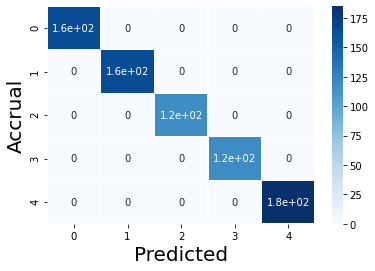

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       165
         1.0       1.00      1.00      1.00       165
         2.0       1.00      1.00      1.00       118
         3.0       1.00      1.00      1.00       119
         4.0       1.00      1.00      1.00       185

    accuracy                           1.00       752
   macro avg       1.00      1.00      1.00       752
weighted avg       1.00      1.00      1.00       752



In [174]:
# ライントレースの判断モデルをテストする

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues', linewidth=0.3)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Accrual", fontsize=20)
plt.show()

print(classification_report(y_test, y_pred))


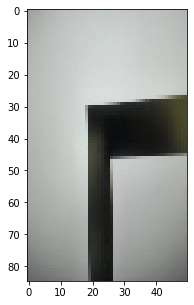

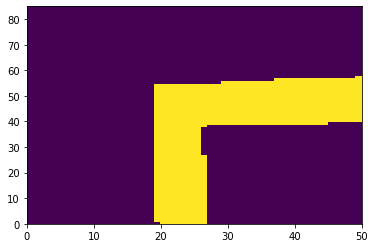

RIGHT90


In [175]:
# ライントレースの判断モデルを使ってタイルを見させてみる

model_color = LoadInstances("ColorModel.pickle")
model_decision = LoadInstances("NeuralDecision.pickle")

# カメラで撮影する
camera = cv2.VideoCapture(0)
ret, raw_frame = camera.read()
frame = cv2.resize(src=raw_frame, dsize=CAMERA_SIZE)
height, width = frame.shape[:2]

# カメラからの写真を表示する
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig = plt.figure(1, (5., 5.))
plt.imshow(img)
plt.pause(0.1)

# 写真を色識別する
result = [model_color.predict(row) for row in reversed(frame)]
plt.clf()
plt.pcolormesh(result)
plt.pause(0.01)

res = model_decision.predict([np.ravel(result)])[0]

acttype = [
    [LEFT_ACTCODE ,"LEFT",],
    [RIGHT_ACTCODE ,"RIGHT",],
    [LEFT90_ACTCODE ,"LEFT90",],
    [RIGHT90_ACTCODE ,"RIGHT90",],
    [STRAIGHT_ACTCODE ,"STRAIGHT",],
]

for at in acttype:
    if res == at[0]:
        print(at[1])